# Main Idia: 

Find the biggest group of people that can imporve thier overall score (health) the most by improving one aspect of their lives by 1 point only: work-stress / workout / weight. than we can tell the company what should they focuse on and in which level.  

one point in weight = 5%

### How? 

start with clustering (using KMeans) to the best clustering num of groups.
than for each cluster check the av. health score. 
change 1 things only (a time) for each person in each cluster and check again what is the overall health score of this group. 

gett the group who changed the most by doing only 1 thing, get its attibutes and letting the company know.

#### Example please: 
letting the company know that young females that have high bmi that are usually practice only 1 time a week, if they will increase their working out level to 2 times (only by one practice a week) they will increase thier health by 34% in avarage. 

This kind of people are 20% of the company. 


In [2]:
import scipy
import numpy as np
import matplotlib
import pandas as pd
import collections


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



import os
import math
import seaborn
import matplotlib.pyplot as plt
import mpl_toolkits
import mpl_toolkits.mplot3d

In [7]:
## just a quick code to check what are the medians in blood_test_score, age and us_test_score. 
input_file="PreSee.csv"

def get_df(file):
    dataset = pd.read_csv(file)
    df = pd.DataFrame(dataset)
    df=df.fillna(0)
    return df
df=get_df(input_file)

def standart_dev(df, col):
    print(df[col].describe()) 

standart_dev(df, "blood_test_score")
print ("--------------")
standart_dev(df, "age")
print ("--------------")
standart_dev(df, "us_test_score")
print ("--------------")
standart_dev(df, "ecg_test_score")
print ("--------------")
standart_dev(df, "bp_diastolic")
print ("--------------")
standart_dev(df, "bp_systolic")






count    1359.000000
mean       83.320088
std         9.313385
min        39.000000
25%        79.000000
50%        87.000000
75%        90.000000
max       101.000000
Name: blood_test_score, dtype: float64
--------------
count    1359.000000
mean       38.015453
std         9.200863
min         4.000000
25%        31.000000
50%        37.000000
75%        44.000000
max        82.000000
Name: age, dtype: float64
--------------
count    1359.000000
mean       97.317145
std        11.337191
min        36.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: us_test_score, dtype: float64
--------------
count    1359.000000
mean       96.512141
std        14.044626
min        40.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: ecg_test_score, dtype: float64
--------------
count    1359.000000
mean       77.578366
std        10.670366
min        42.000000
25%        70.000000
50%        77.000000
75% 

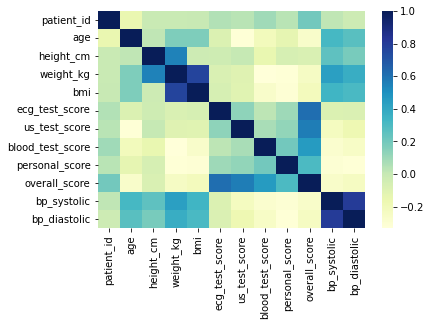

In [6]:
import seaborn as sns
# Plot the correlation heatmap
sns.heatmap(df.corr(), cmap="YlGnBu", annot=);

## DATA CLEANING

### modifide the table in xcel: 

changed values to numeric values: 
female = 1 , male = 0
Yes = 1 , NO = 0

added columns for making results in 1 / 0: 

bmi_bit  = IF(AND(bmi>18.5,bmi<25),1,0) meaining if good than 1 else 0;
acg_core_bit = IF(acd=100,1,0) meaining if was 100 than 1 else 0; (more than 75% got 100)
us_test_score_bit = IF(us_test_score>=60, 1, 0) 1 above median score , 0 less. 
blood_test_score_bit = =IF(blood_test_score>=87, 1, 0) ## if over or less than median. 
bp_systolic_bit =  IF(bp_systolic > 125, 0, 1) ## to hign by check medicine articles. 
bp_diastolic_bit = IF(AE2<=80, 1, 0) ## to low by check medicine articles. 

In [63]:
input_file="PreSeeNormFilterd.csv"

In [64]:
def get_df(file):
    dataset = pd.read_csv(file)
    df = pd.DataFrame(dataset)
    df=df.fillna(0)
    return df
original_df=get_df(input_file)
#TEST for Bits information 
#OriginalBit_df= get_df("PreSeeEditedBit.csv")

In [65]:
original_df

,patient_id,gender,gender_norm,age,age_norm,height_cm,weight_kg,bmi,bmi_norm,ecg_test_score,...,diabetes_factor,diabetes_norm,work_stress_level,stress_norm,exercise_level,exercies_norm,bp_systolic,bp_sys_norm,bp_diastolic,bp_di_norm
0,1.0,1.000000,1.313968,41.000000,0.365088,170.0,52.0,18.000000,-1.727775,100.000000,...,2.0,0.055685,0.400000,-0.645188,0.800000,0.980922,112.000000,-0.517110,75.000000,-0.209134
1,2.0,0.000000,-0.760465,26.000000,-1.336637,173.0,60.0,20.000000,-1.194470,100.000000,...,2.0,0.055685,0.400000,-0.645188,0.200000,-1.395716,128.000000,0.574966,84.000000,0.677458
2,3.0,0.000000,-0.760465,38.000000,0.024743,172.0,65.0,22.000000,-0.661166,100.000000,...,2.0,0.055685,0.400000,-0.645188,0.800000,0.980922,117.000000,-0.175837,79.000000,0.184907
3,4.0,1.000000,1.313968,39.000000,0.138191,160.0,67.0,26.000000,0.405443,100.000000,...,2.0,0.055685,0.800000,1.430007,0.600000,0.188710,96.000000,-1.609187,61.000000,-1.588277
4,5.0,0.000000,-0.760465,33.000000,-0.542499,176.0,79.0,26.000000,0.405443,100.000000,...,2.0,0.055685,0.400000,-0.645188,0.600000,0.188710,117.000000,-0.175837,76.000000,-0.110624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1357.0,1.000000,1.313968,36.000000,-0.202154,160.0,51.0,20.000000,-1.194470,100.000000,...,2.0,0.055685,0.600000,0.392409,0.200000,-1.395716,133.000000,0.916240,85.000000,0.775968
1291,1358.0,0.000000,-0.760465,27.000000,-1.223188,169.0,88.0,31.000000,1.738705,100.000000,...,2.0,0.055685,0.600000,0.392409,0.400000,-0.603503,118.000000,-0.107582,81.000000,0.381927
1292,1359.0,0.000000,-0.760465,32.000000,-0.655947,176.0,77.0,25.000000,0.138791,100.000000,...,2.0,0.055685,0.600000,0.392409,0.400000,-0.603503,122.000000,0.165437,73.000000,-0.406155
1293,0.0,0.366589,0.000000,37.781903,0.000000,0.0,0.0,24.479505,0.000000,96.751740,...,0.0,0.000000,0.524362,0.000000,0.552359,0.000000,119.576179,0.000000,77.122970,0.000000


In [66]:
##Cleaning table to just be with relevant columns to our model. (withput changable things)

df = original_df[["gender", "bmi_norm", "acg_norm" ,  "us_norm", "blood_norm" , "heart_hist_factor" , "family_hist_norm", "bp_med_norm_half", "diabetes_factor", "bp_sys_norm" ,"bp_di_norm"  ]]
df

##TEST for Bits information:
#dfBit =  OriginalBit_df [["gender", "age_bit", "bmi_bit","ecg_test_score_bit", "us_test_score_bit", "blood_test_score_bit", "heart_disease_hist", "heart_disease_family_hist", "diabetes", "bp_systolic_bit", "bp_diastolic_bit"]]

,gender,bmi_norm,acg_norm,us_norm,blood_norm,heart_hist_factor,family_hist_norm,bp_med_norm_half,diabetes_factor,bp_sys_norm,bp_di_norm
0,1.000000,-1.727775,0.239149,0.221099,1.591687,3.0,0.356637,0.088143,2.0,-0.517110,-0.209134
1,0.000000,-1.194470,0.239149,0.221099,0.715967,3.0,-2.801801,0.088143,2.0,0.574966,0.677458
2,0.000000,-0.661166,0.239149,0.221099,0.059177,3.0,0.356637,0.088143,2.0,-0.175837,0.184907
3,1.000000,0.405443,0.239149,0.221099,0.825432,3.0,0.356637,0.088143,2.0,-1.609187,-1.588277
4,0.000000,0.405443,0.239149,0.221099,-1.801728,3.0,0.356637,0.088143,2.0,-0.175837,-0.110624
...,...,...,...,...,...,...,...,...,...,...,...
1290,1.000000,-1.194470,0.239149,0.221099,0.934897,3.0,-2.801801,0.088143,2.0,0.916240,0.775968
1291,0.000000,1.738705,0.239149,0.221099,-0.050288,3.0,0.356637,0.088143,2.0,-0.107582,0.381927
1292,0.000000,0.138791,0.239149,0.221099,0.387572,3.0,0.356637,0.088143,2.0,0.165437,-0.406155
1293,0.366589,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [67]:
##creating male df
df_male = df[df["gender"] == 0];
df_male


,gender,bmi_norm,acg_norm,us_norm,blood_norm,heart_hist_factor,family_hist_norm,bp_med_norm_half,diabetes_factor,bp_sys_norm,bp_di_norm
1,0.0,-1.194470,0.239149,0.221099,0.715967,3.0,-2.801801,0.088143,2.0,0.574966,0.677458
2,0.0,-0.661166,0.239149,0.221099,0.059177,3.0,0.356637,0.088143,2.0,-0.175837,0.184907
4,0.0,0.405443,0.239149,0.221099,-1.801728,3.0,0.356637,0.088143,2.0,-0.175837,-0.110624
5,0.0,-0.394513,0.239149,-3.899035,-0.816543,3.0,-2.801801,0.088143,2.0,0.711476,0.381927
6,0.0,-0.127861,0.239149,0.221099,-0.378683,3.0,0.356637,0.088143,2.0,0.643221,0.972988
...,...,...,...,...,...,...,...,...,...,...,...
1287,0.0,-0.394513,0.239149,0.221099,0.606502,3.0,0.356637,0.088143,2.0,-0.175837,-0.209134
1288,0.0,-1.461123,0.239149,0.221099,0.606502,3.0,0.356637,0.088143,2.0,-0.107582,-0.406155
1289,0.0,-0.127861,0.239149,0.221099,0.387572,3.0,-2.801801,0.088143,2.0,-0.926639,0.381927
1291,0.0,1.738705,0.239149,0.221099,-0.050288,3.0,0.356637,0.088143,2.0,-0.107582,0.381927


In [68]:
## creating female df

df_female = df[df["gender"] == 1];
df_female

,gender,bmi_norm,acg_norm,us_norm,blood_norm,heart_hist_factor,family_hist_norm,bp_med_norm_half,diabetes_factor,bp_sys_norm,bp_di_norm
0,1.0,-1.727775,0.239149,0.221099,1.591687,3.0,0.356637,0.088143,2.0,-0.517110,-0.209134
3,1.0,0.405443,0.239149,0.221099,0.825432,3.0,0.356637,0.088143,2.0,-1.609187,-1.588277
9,1.0,-0.661166,0.239149,0.221099,-0.707078,3.0,0.356637,0.088143,2.0,-0.585365,-0.701685
15,1.0,0.138791,0.239149,0.221099,0.606502,3.0,-2.801801,0.088143,2.0,2.213081,1.958090
16,1.0,0.938748,0.239149,0.221099,-2.567983,3.0,0.356637,0.088143,2.0,-0.039327,0.283417
...,...,...,...,...,...,...,...,...,...,...,...
1276,1.0,0.138791,0.239149,0.221099,-0.707078,3.0,0.356637,0.088143,2.0,-0.312346,-0.603175
1278,1.0,-1.994427,0.239149,0.221099,0.715967,3.0,0.356637,0.088143,2.0,-0.312346,-0.701685
1281,1.0,-1.194470,0.239149,0.221099,0.387572,3.0,0.356637,-2.834121,2.0,-0.653620,-0.307644
1282,1.0,-1.994427,0.239149,0.221099,0.606502,3.0,0.356637,0.088143,2.0,-1.336168,-0.307644


## Choosing the right K:


In [69]:
distance_metric='euclidean'
k_range = np.arange(2, 10, 1)

In [70]:
# Build model function
def get_clusterer(points,k):
    clusterer = KMeans (n_clusters=k)
    preds = clusterer.fit_predict(points)
    return clusterer,preds

clusterer,preds=get_clusterer(df,5)
clusterer_male,preds_male=get_clusterer(df_male,1)
clusterer_female,preds_female=get_clusterer(df_female,1)
#TEST for Bits information 
#clustererBit,predsBit = get_clusterer(dfBit,5)

In [71]:
#bulding the model for each K in range 2 to 10. 
def get_silheuettes(df,preds):
    Silhouettes = []
    for k in k_range:
        clusterer,preds=get_clusterer(df,k)
        Silhouettes.append(silhouette_score (df, preds, metric='euclidean'))
    return Silhouettes

Silhouettes = get_silheuettes(df,preds)
Silhouettes_male = get_silheuettes(df_male,preds_male)
Silhouettes_female = get_silheuettes(df_female,preds_female)
#TEST for Bits information 
#SilhouettesBit =  get_silheuettes(dfBit,predsBit)


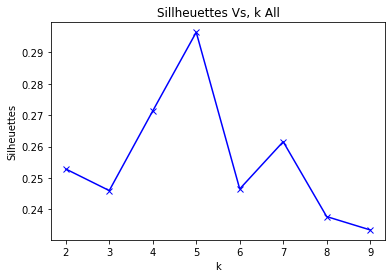

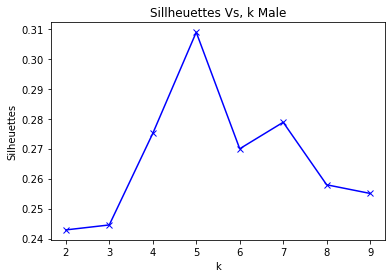

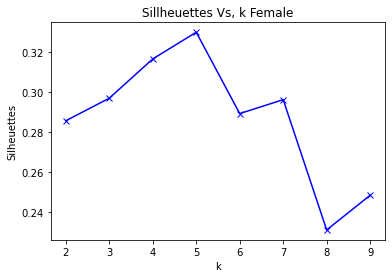

In [72]:
# plot the silhouttes results. 
def show_silhouettes (Silhouettes, str):
    plt.plot(k_range, Silhouettes, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silheuettes')
    plt.title('Sillheuettes Vs, k' + " " + str)
    plt.show()
    
    
show_silhouettes(Silhouettes, "All")
show_silhouettes(Silhouettes_male, "Male")
show_silhouettes(Silhouettes_female, "Female")
#TEST for Bits information 
#show_silhouettes(SilhouettesBit, "All Bit")

## Building The Model For Best K

In [118]:
# Build model for K=5
K=5
def get_clusterer(points,k):
    clusterer = KMeans (n_clusters=k)
    preds = clusterer.fit_predict(points)
    return clusterer,preds
clusterer,preds=get_clusterer(df,K)


In [121]:
def show_labels_results (clusterer):
    print('labels:', clusterer.labels_, '\n') 
#show_labels_results(clusterer)

print(len(clusterer.labels_))

##How many data points we have in each group

labels = clusterer.labels_

collections.Counter(labels)


1295


Counter({0: 634, 2: 126, 1: 415, 4: 61, 3: 59})

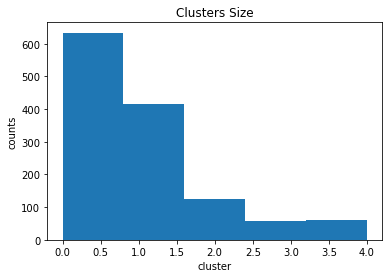

In [122]:
def plot_histogram(labels):
        n_unique_categories = 5
        plt.hist(labels, bins=n_unique_categories)
        plt.xlabel("cluster")
        plt.ylabel("counts")
        plt.title("Clusters Size")
plot_histogram(labels)


centroids:
0 : [ 0.49818399 -0.49126573  0.23839416  0.2204016   0.41898185  2.95268139
  0.35551222  0.06020899  1.99053628 -0.57404476 -0.57206092] 

1 : [ 0.19036145  0.65538987  0.23914857  0.22109908 -0.57809385  2.94216867
  0.34141587 -0.04564787  2.          0.72940267  0.76528589] 

2 : [ 0.38095238 -0.08341907  0.23914857  0.22109907 -0.04768156  2.85714286
 -2.80180093 -0.02782032  1.96825397 -0.05232791 -0.05433243] 

3 : [ 2.88135593e-01  8.45568175e-02 -4.17826713e+00  2.21099075e-01
 -3.90439107e-03  2.89830508e+00  8.89730055e-02  8.81425340e-02
  2.00000000e+00  1.50398137e-01  1.24798681e-01] 

4 : [ 0.24590164  0.73766604 -0.55743459 -4.4654764  -0.31946412  2.80327869
 -0.31647252 -0.34301117  1.96721311  0.96659171  0.73074992] 



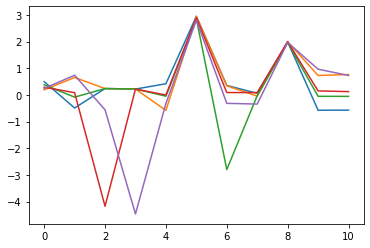

In [123]:
def show_results (clusterer):
    centers = clusterer.cluster_centers_
    print('centroids:')
    for i in range(K):
        print(i,':',centers[i,:],'\n')
    for i in range(K):
        plt.plot(centers[i,:])
        
show_results(clusterer)

#df

# PART 3: Conclusions.

In this part we want to take the clusters that the Kmeans created and look at the columns that we didnt include in the algorithem. like : weight, smoking, work_stress_level, exercise level. and try to see if there are any differences between the groups, so we can know what field and which group should we be focusing more - so we can save more lifes. 


In [126]:
# insert label column
new_df = original_df
new_df.insert(0, "Kmeans_label", labels)


In [128]:
new_df

,Kmeans_label,patient_id,gender,gender_norm,age,age_norm,height_cm,weight_kg,bmi,bmi_norm,...,diabetes_factor,diabetes_norm,work_stress_level,stress_norm,exercise_level,exercies_norm,bp_systolic,bp_sys_norm,bp_diastolic,bp_di_norm
0,0,1.0,1.000000,1.313968,41.000000,0.365088,170.0,52.0,18.000000,-1.727775,...,2.0,0.055685,0.400000,-0.645188,0.800000,0.980922,112.000000,-0.517110,75.000000,-0.209134
1,2,2.0,0.000000,-0.760465,26.000000,-1.336637,173.0,60.0,20.000000,-1.194470,...,2.0,0.055685,0.400000,-0.645188,0.200000,-1.395716,128.000000,0.574966,84.000000,0.677458
2,0,3.0,0.000000,-0.760465,38.000000,0.024743,172.0,65.0,22.000000,-0.661166,...,2.0,0.055685,0.400000,-0.645188,0.800000,0.980922,117.000000,-0.175837,79.000000,0.184907
3,0,4.0,1.000000,1.313968,39.000000,0.138191,160.0,67.0,26.000000,0.405443,...,2.0,0.055685,0.800000,1.430007,0.600000,0.188710,96.000000,-1.609187,61.000000,-1.588277
4,1,5.0,0.000000,-0.760465,33.000000,-0.542499,176.0,79.0,26.000000,0.405443,...,2.0,0.055685,0.400000,-0.645188,0.600000,0.188710,117.000000,-0.175837,76.000000,-0.110624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,2,1357.0,1.000000,1.313968,36.000000,-0.202154,160.0,51.0,20.000000,-1.194470,...,2.0,0.055685,0.600000,0.392409,0.200000,-1.395716,133.000000,0.916240,85.000000,0.775968
1291,1,1358.0,0.000000,-0.760465,27.000000,-1.223188,169.0,88.0,31.000000,1.738705,...,2.0,0.055685,0.600000,0.392409,0.400000,-0.603503,118.000000,-0.107582,81.000000,0.381927
1292,0,1359.0,0.000000,-0.760465,32.000000,-0.655947,176.0,77.0,25.000000,0.138791,...,2.0,0.055685,0.600000,0.392409,0.400000,-0.603503,122.000000,0.165437,73.000000,-0.406155
1293,0,0.0,0.366589,0.000000,37.781903,0.000000,0.0,0.0,24.479505,0.000000,...,0.0,0.000000,0.524362,0.000000,0.552359,0.000000,119.576179,0.000000,77.122970,0.000000


In [127]:
def getSize(df, newdf):
    print('overall',df.shape[0]*100/newdf.shape[0], '% from all people')

In [145]:
 # family hist.
df_fm = new_df[new_df["Kmeans_label"] == 2];
print(" --------- family hist ------------")
getSize(df_fm, new_df)

## low US score
df_us = new_df[new_df["Kmeans_label"] == 4];
print(" --------- low US score ------------")
getSize(df_us, new_df)


## low ECG score
df_ecg = new_df[new_df["Kmeans_label"] == 3];
print(" --------- low ECG score ------------")
getSize(df_ecg, new_df)

## low ECG score

df_others = new_df[new_df["Kmeans_label"] <= 1 ];

print(" --------- others ------------")
getSize(df_others, new_df)





 --------- family hist ------------
overall 9.72972972972973 % from all people
 --------- low US score ------------
overall 4.710424710424711 % from all people
 --------- low ECG score ------------
overall 4.555984555984556 % from all people
 --------- others ------------
overall 81.003861003861 % from all people


 --------- family hist ------------
7 numbers statistics
               age   weight_kg     smoking  work_stress_level  exercise_level
count  126.000000  126.000000  126.000000         126.000000      126.000000
mean    38.230159   72.849206    0.801587           0.523810        0.539683
std      8.720700   14.858838    0.400397           0.209925        0.237682
min     21.000000   43.000000    0.000000           0.000000        0.200000
25%     31.250000   63.000000    1.000000           0.400000        0.400000
50%     37.000000   72.000000    1.000000           0.600000        0.600000
75%     44.000000   84.000000    1.000000           0.600000        0.800000
max     60.000000  110.000000    1.000000           1.000000        1.000000
Box and Whisker for selected columns
 AxesSubplot(0.125,0.125;0.775x0.755)


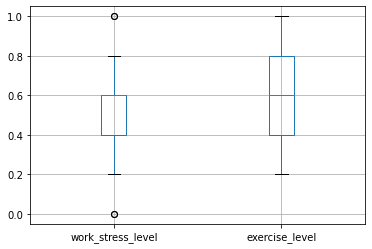

In [146]:

def plot_statistics(dataframe,selected_columns):
    print('7 numbers statistics\n',dataframe.describe())
    
    #print('Box and Whisker\n',dataframe.boxplot())
    print('Box and Whisker for selected columns\n',dataframe.boxplot(column=selected_columns) ) 


feat = ["age","weight_kg","smoking", "work_stress_level", "exercise_level"]
print(" --------- family hist ------------")    
plot_statistics(df_fm[feat],['work_stress_level', 'exercise_level'])




 --------- low US score ------------
7 numbers statistics
              age   weight_kg    smoking  work_stress_level  exercise_level
count  61.000000   61.000000  61.000000          61.000000       61.000000
mean   49.147541   80.983607   0.885246           0.491803        0.603279
std     8.481030   15.355229   0.321370           0.205179        0.269547
min    30.000000   48.000000   0.000000           0.000000        0.200000
25%    42.000000   70.000000   1.000000           0.400000        0.400000
50%    48.000000   82.000000   1.000000           0.600000        0.600000
75%    56.000000   90.000000   1.000000           0.600000        0.800000
max    65.000000  125.000000   1.000000           1.000000        1.000000
Box and Whisker for selected columns
 AxesSubplot(0.125,0.125;0.775x0.755)


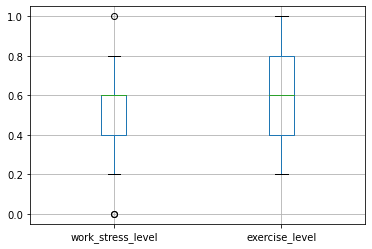

In [147]:
print(" --------- low US score ------------")
plot_statistics(df_us[feat],['work_stress_level', 'exercise_level'])

#older people. 
#practice like avg. 
#work stress level meadinan 3/5 but avg 0.5 ike everyone. 

 --------- low ECG score ------------
7 numbers statistics
              age   weight_kg    smoking  work_stress_level  exercise_level
count  59.000000   59.000000  59.000000          59.000000       59.000000
mean   39.186441   74.932203   0.745763           0.535593        0.572881
std     9.631977   14.138312   0.439169           0.239081        0.261185
min    24.000000   49.000000   0.000000           0.000000        0.200000
25%    31.000000   65.500000   0.500000           0.400000        0.400000
50%    38.000000   75.000000   1.000000           0.600000        0.600000
75%    46.000000   84.000000   1.000000           0.600000        0.800000
max    64.000000  107.000000   1.000000           1.000000        1.000000
Box and Whisker for selected columns
 AxesSubplot(0.125,0.125;0.775x0.755)


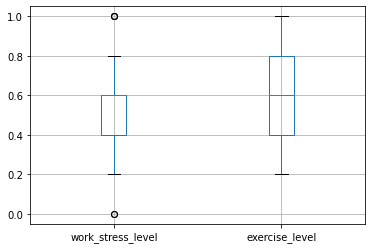

In [148]:
print(" --------- low ECG score ------------")
plot_statistics(df_ecg[feat],['work_stress_level', 'exercise_level'])

 --------- Others ------------
7 numbers statistics
                age    weight_kg      smoking  work_stress_level  \
count  1049.000000  1049.000000  1049.000000        1049.000000   
mean     36.960530    72.683508     0.863877           0.525374   
std       8.362687    14.722332     0.342591           0.187107   
min       8.814589     0.000000     0.000000           0.000000   
25%      31.000000    62.000000     1.000000           0.400000   
50%      36.000000    72.000000     1.000000           0.600000   
75%      42.000000    83.000000     1.000000           0.600000   
max      65.000000   125.000000     1.000000           1.000000   

       exercise_level  
count     1049.000000  
mean         0.549480  
std          0.252555  
min          0.200000  
25%          0.400000  
50%          0.600000  
75%          0.800000  
max          1.000000  
Box and Whisker for selected columns
 AxesSubplot(0.125,0.125;0.775x0.755)


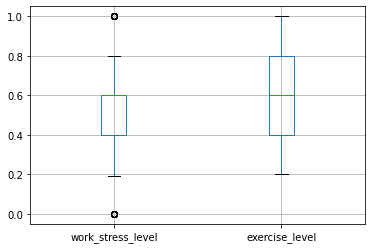

In [149]:
print(" --------- Others ------------")
plot_statistics(df_others[feat],['work_stress_level', 'exercise_level'])



# Problems: 
1. it looks like that doesnt matter if we take the man / women / all table the clusters are geting better as we increase K. 
2. as we are making the K higher we are getting less equal ampunt of people in every cluster. (there are few clusters with a lot of people, and alot of other small clusters with a lot less people in). 
3. the clusters graph doesnt seem to be veryy different between another. (doesnt matter what K we choose and that df all / male / female. 

# Possible Solutions? 
1. we are not sure why it happends. is it becouse we did somthing to obviece in our pre-proccesing of the file? what can we do  different there? is there a way to tell the algorithem what is more important and what is less? is there a way for us to k ow what is more important and what is less (for example its quite clear that if you had hurt problems in the past it should be with more wight than have a littlbit high blood presure but we are not sure how to do that. 

2. should we try to choose the K with the best distribution? 

3. again? anything that we did with prepering the data?

4. we are open to hear any suggestions. 